In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore

**You might get lost from here on. So, we decided to provide you with sections.**  
&emsp;1) [Load Data](#loaddata)  
&emsp;2) [Quick Clean-Up for EDA](#firstcleanup)  
&emsp;3) [Analyze Data and EDA](#eda)  
&emsp;4) [Create Preprocessing Pipeline](#prepro)  
&emsp;5) [Analysis Methods](#modelling)  
&emsp;6) [Ethical Considerations](#ethics)

# 1) Load Data <a name="loaddata"></a>

In [4]:
df = pd.read_csv('adult_reconstruction.csv')
df

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49526,65,35,0,0,Private,Bachelors,13,Married-civ-spouse,Husband,White,Male,Yugoslavia,85080,Farming-fishing
49527,77,37,3137,0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Vietnam,34137,Sales
49528,55,24,0,0,Private,Assoc-voc,11,Never-married,Not-in-family,White,Male,United-States,13016,Sales
49529,40,24,0,0,Private,Some-college,10,Never-married,Not-in-family,White,Female,United-States,15000,Adm-clerical


# 2) Quick Clean-Up for EDA <a name="firstcleanup"></a>

#### Fix missing values

In [5]:
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

#### There are some cells with ? in it, so we replace with nans and check the percentage of missing values.

In [6]:
df.isin(['?']).sum()

hours-per-week       0
age                  0
capital-gain         0
capital-loss         0
workclass         2859
education            0
education-num        0
marital-status       0
relationship         0
race                 0
gender               0
native-country     859
income               0
occupation        2869
dtype: int64

In [7]:
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native-country'] = df['native-country'].replace('?', np.nan)


In [7]:
perc1 = df['workclass'].isnull().sum()/len(df['workclass'])*100
perc2 = df['occupation'].isnull().sum()/len(df['occupation'])*100
perc3 = df['native-country'].isnull().sum()/len(df['native-country'])*100
print("Missing =", perc1,"% in 'workclass',", perc2,"% in 'occupation',", perc3,"% in 'native-country'")


Missing = 5.7721426985120425 % in 'workclass', 5.792332074862207 % in 'occupation', 1.7342674284791342 % in 'native-country'


In [8]:
lenBefore = df['workclass']
df.dropna(how='any', inplace=True)
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

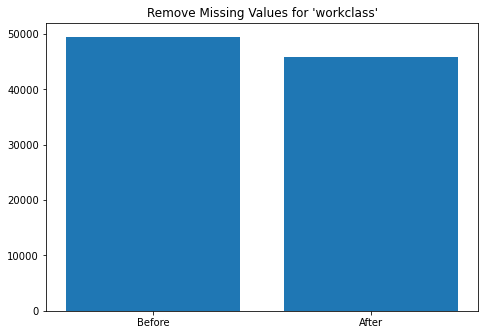

In [9]:
lenAfter = df['workclass']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xaxis = ['Before', 'After']
yaxis = [len(lenBefore), len(lenAfter)]
ax.bar(xaxis,yaxis)
plt.title("Remove Missing Values for 'workclass'")
plt.show()

In [10]:
## Check if there are any duplicate rows
df.duplicated().sum()

208

In [11]:
df = df.drop_duplicates()

In [52]:
#Encode the occupations into numbers for the plot below
dictt = dict()
count = 1
for k in list(set(list(df['occupation']))):
    dictt[k]=count
    count+=1
print(dictt)

newdf = df.copy()
for d in dictt:
    newdf=newdf.replace(d, dictt[d])

{'Exec-managerial': 1, 'Priv-house-serv': 2, 'Farming-fishing': 3, 'Sales': 4, 'Tech-support': 5, 'Prof-specialty': 6, 'Handlers-cleaners': 7, 'Adm-clerical': 8, 'Armed-Forces': 9, 'Protective-serv': 10, 'Other-service': 11, 'Transport-moving': 12, 'Machine-op-inspct': 13, 'Craft-repair': 14}


In [110]:
len(newdf[newdf['race']=='White'])

39320

### newDATA is the data where the number males and females working in an occupation is made to be equal

In [93]:
listCounts=dict()
newDATA = pd.DataFrame()
for d in dictt:
    
    occupation = dictt[d]
    temp = newdf[newdf['occupation']==occupation]
    
    male = temp[temp['gender']=='Male']
    female = temp[temp['gender']=='Female']
    
    countMale = len(male)
    countFemale = len(female)
    
    listCounts[occupation] = [countMale, countFemale]
    
    #find the minimum then which gender is the min
    minn = min(listCounts[occupation])
    gender = listCounts[occupation].index(minn) ## if 0 then male, if 1 then female
    
    diff = abs(countMale-countFemale)
    
    if gender==0: ## then females need to be removed
        female= female.drop(female.index[len(female)-diff:len(female)], inplace=False)
    else:
        male = male.drop(male.index[len(male)-diff:len(male)], inplace=False)

    newDATA = pd.concat([newDATA, female], axis=0)
    newDATA = pd.concat([newDATA, male], axis=0)

# 3) Analyze Data & EDA <a name="eda"></a>

&emsp;1) [Is there a relationship between sex/race/age and income?](#1)  
&emsp;2) [Is a certain sex/race preferred in a certain occupation given the same education levels?](#2)  
&emsp;3) [Which group of people (considering age, sex, race, marital status) is working the most in terms of hours per week?](#3)  
&emsp;4) [How are the occupation types distributed over the genders?](#4) 


### 3.1) Is there a relationship between sex/race/age and income? <a name="1"></a>

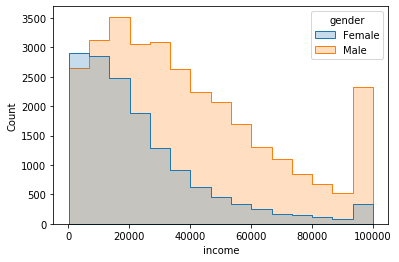

In [13]:
sns.histplot(data=df, x="income", bins=15, hue='gender', element="step")

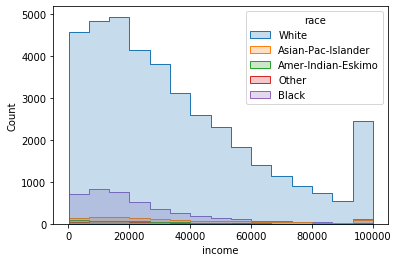

In [14]:
sns.histplot(data=df, x="income", bins=15, hue='race', element="step")

Since we have ages from 17 to 90, we need to group them so we can plot it with income. So, let's first look at the age distribution:

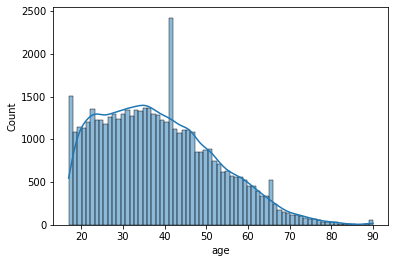

In [9]:
sns.histplot(df['age'], bins=70, kde=True)

We have a lot of 17 and 40 years olds. So, we suggest this grouping:  
Group 1: <=20  
Group 2: >20 and <40  
Group 3: >= 40 and <65 (average retiring age)  
Group 4: >= 65

In [10]:
temp = []
for i in df['age']:
    if i <= 20:
        temp.append("Group 1")
    if (i>20) and (i<40):
        temp.append("Group 2")
    if (i>=40) and (i<65):
        temp.append("Group 3")
    if (i>=65):
        temp.append("Group 4")
        
copiedDF = df.copy()
copiedDF['Grouped Ages'] = temp

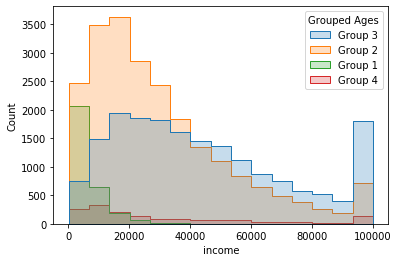

In [17]:
sns.histplot(data=copiedDF, x="income", bins=15, hue='Grouped Ages', element="step")

### 3.2) Is a certain sex preferred in a certain occupation given the same education levels? <a name="2"></a>

In [32]:
dicttEd = dict()
count = 1
for k in list(set(list(df['education']))):
    dicttEd[k]=count
    count+=1
    
for d in dicttEd:
    copiedDF=copiedDF.replace(d, dicttEd[d])
dicttEd

{'Doctorate': 1,
 'Bachelors': 2,
 'Prof-school': 3,
 'Assoc-acdm': 4,
 '11th': 5,
 '5th-6th': 6,
 'Assoc-voc': 7,
 '7th-8th': 8,
 'HS-grad': 9,
 '9th': 10,
 '12th': 11,
 '1st-4th': 12,
 'Masters': 13,
 'Some-college': 14,
 '10th': 15,
 'Preschool': 16}

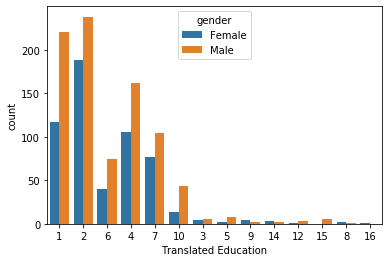

In [31]:
sns.countplot(data=copiedDF.loc[copiedDF['occupation']=='Tech-support'], x='Translated Education', hue='gender')

In [26]:
# If you wanna see another occupation
column_values = df[["occupation"]].values.ravel()
unique_values =  pd.unique(column_values)
unique_values

array(['Tech-support', 'Craft-repair', 'Other-service', 'Sales',
       'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners',
       'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing',
       'Transport-moving', 'Priv-house-serv', 'Protective-serv',
       'Armed-Forces'], dtype=object)

### 3.3) Which group of people (considering age, sex, race, marital status) is working the most in terms of hours per week? <a name="3"></a>

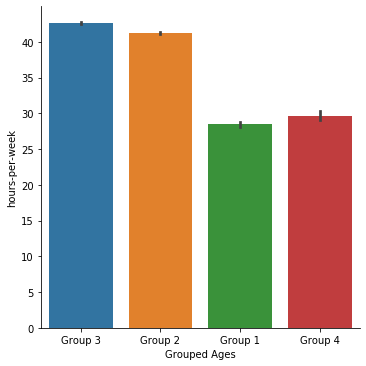

In [22]:
sns.catplot(data=copiedDF, kind="bar", x="Grouped Ages", y="hours-per-week")

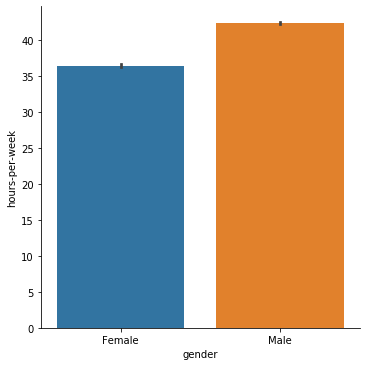

In [21]:
sns.catplot(data=df, kind="bar", x="gender", y="hours-per-week")

In [17]:
dicttRace = dict()
count = 1
for k in list(set(list(df['race']))):
    dicttRace[k]=count
    count+=1
    
for d in dicttRace:
    copiedDF=copiedDF.replace(d, dicttRace[d])
dicttRace

{'Amer-Indian-Eskimo': 1,
 'Asian-Pac-Islander': 2,
 'Black': 3,
 'Other': 4,
 'White': 5}

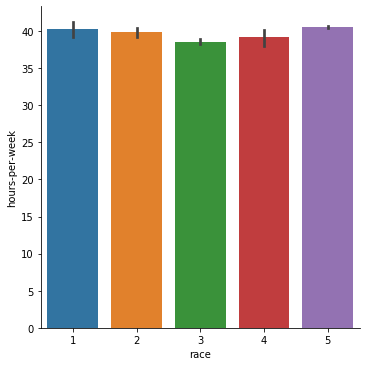

In [20]:
sns.catplot(data=copiedDF, kind="bar", x="race", y="hours-per-week")

In [16]:
dicttMS = dict()
count = 1
for k in list(set(list(df['marital-status']))):
    dicttMS[k]=count
    count+=1
    
for d in dicttMS:
    copiedDF=copiedDF.replace(d, dicttMS[d])
dicttMS

{'Married-spouse-absent': 1,
 'Separated': 2,
 'Widowed': 3,
 'Divorced': 4,
 'Never-married': 5,
 'Married-AF-spouse': 6,
 'Married-civ-spouse': 7}

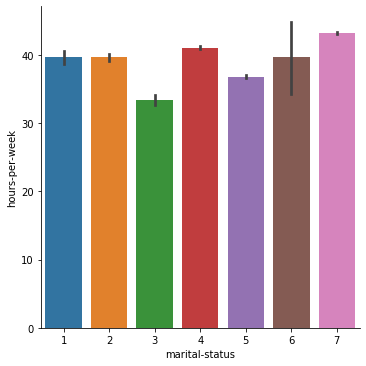

In [15]:
sns.catplot(data=copiedDF, kind="bar", x="marital-status", y="hours-per-week")

### 3.4) How are the occupation types distributed over the genders? <a name="4"></a>

In [41]:
#Encode the occupations into numbers for the plot below
dictt = dict()
count = 1
for k in list(set(list(df['occupation']))):
    dictt[k]=count
    count+=1
    
for d in dictt:
    copiedDF=copiedDF.replace(d, dictt[d])
dictt

{'Machine-op-inspct': 1,
 'Sales': 2,
 'Protective-serv': 3,
 'Exec-managerial': 4,
 'Other-service': 5,
 'Adm-clerical': 6,
 'Transport-moving': 7,
 'Handlers-cleaners': 8,
 'Prof-specialty': 9,
 'Farming-fishing': 10,
 'Priv-house-serv': 11,
 'Armed-Forces': 12,
 'Tech-support': 13,
 'Craft-repair': 14}

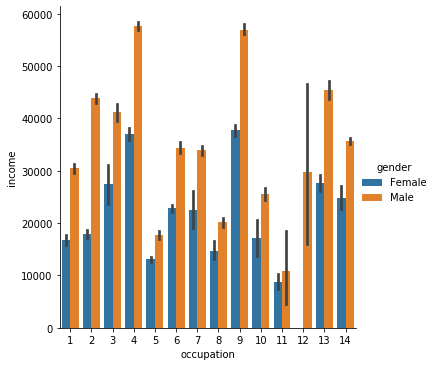

In [43]:
sns.catplot(data=copiedDF, kind="bar", x="occupation", y="income", hue="gender")

# -------------------------------------------------------------------------------------

In [13]:
print(df.shape)
df.describe()

(45641, 14)


,hours-per-week,age,capital-gain,capital-loss,education-num,income
count,45641.000000,45641.000000,45641.000000,45641.000000,45641.00000,45641.000000
mean,40.915120,38.487566,1080.570759,87.546307,10.10438,34417.740606
std,11.966191,13.211451,7426.000706,402.596785,2.54683,26870.885616
min,1.000000,17.000000,0.000000,0.000000,1.00000,107.000000
25%,40.000000,28.000000,0.000000,0.000000,9.00000,13200.000000
50%,40.000000,37.000000,0.000000,0.000000,10.00000,27260.000000
75%,45.000000,47.000000,0.000000,0.000000,12.00000,49515.000000
max,99.000000,90.000000,99999.000000,4356.000000,16.00000,99999.000000


In [14]:
# The highest correlation is 0.408262, education-num and income
df.corr(method ='pearson')

,hours-per-week,age,capital-gain,capital-loss,education-num,income
hours-per-week,1.000000,0.103021,0.083526,0.054216,0.146021,0.347593
age,0.103021,1.000000,0.079491,0.059786,0.038265,0.325923
capital-gain,0.083526,0.079491,1.000000,-0.031643,0.126109,0.287423
capital-loss,0.054216,0.059786,-0.031643,1.000000,0.082126,0.172733
education-num,0.146021,0.038265,0.126109,0.082126,1.000000,0.408262
income,0.347593,0.325923,0.287423,0.172733,0.408262,1.000000


<AxesSubplot:>

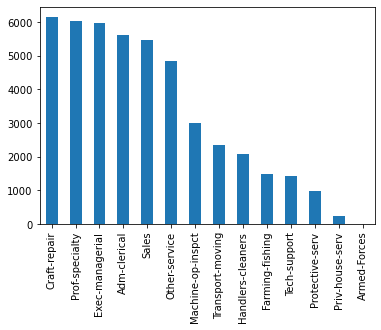

In [15]:
occ=df['occupation'].value_counts()
occ.plot.bar()

<AxesSubplot:>

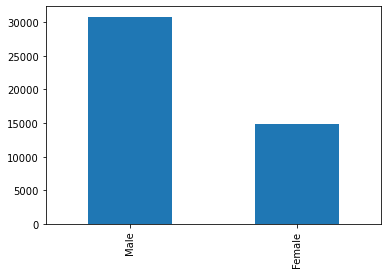

In [16]:
gender=df['gender'].value_counts()
gender.plot.bar()

{'Exec-managerial': 1,
 'Priv-house-serv': 2,
 'Farming-fishing': 3,
 'Sales': 4,
 'Tech-support': 5,
 'Prof-specialty': 6,
 'Handlers-cleaners': 7,
 'Adm-clerical': 8,
 'Armed-Forces': 9,
 'Protective-serv': 10,
 'Other-service': 11,
 'Transport-moving': 12,
 'Machine-op-inspct': 13,
 'Craft-repair': 14}

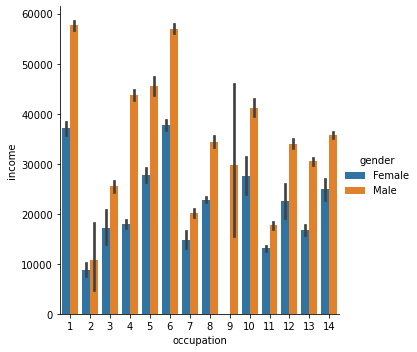

In [19]:
## cat plot of occupation and gender
## we need to show the x label better maybe with numbers
sns.catplot(data=newdf, kind="bar", x="occupation", y="income", hue="gender")

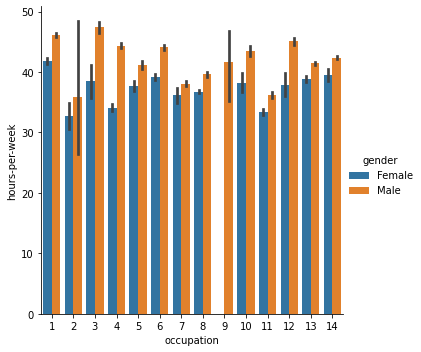

In [98]:
## cat plot of hours and gender
# We can see that men usually work more. To better visualize this, a histplot has been contstructed below
sns.catplot(data=newdf, kind="bar", x="occupation", y="hours-per-week", hue="gender")

99497.03015075377


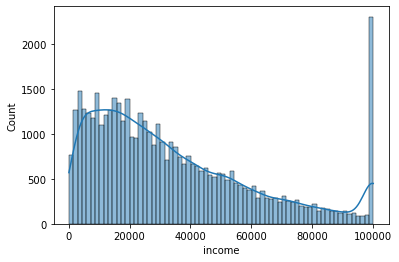

In [21]:
ax = sns.histplot(df['income'], bins=70, kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

##The last bin to remove
print(xs[-2])

<AxesSubplot:xlabel='hours-per-week', ylabel='Count'>

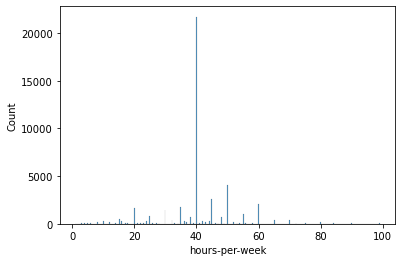

In [22]:
sns.histplot(df['hours-per-week'])
# we need to decrease the number of bins to better understand the plot

<AxesSubplot:xlabel='occupation', ylabel='count'>

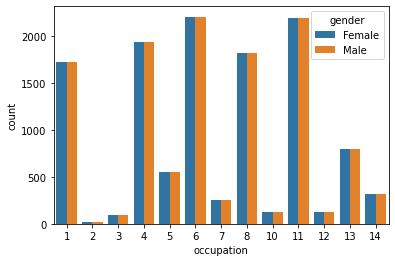

In [100]:
sns.countplot(data=newDATA, x='occupation', hue='gender')

<AxesSubplot:xlabel='hours-per-week', ylabel='Count'>

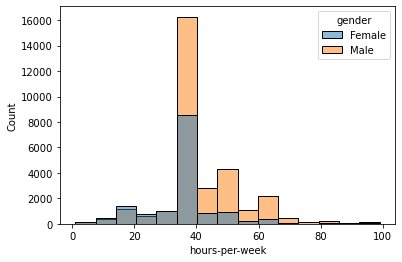

In [23]:
sns.histplot(data=df, x="hours-per-week", bins=15, hue='gender')
#Here we can see the differnece in the hours worked per week between the 2 genders
# we can also see that there are outliers that need to be removed
# It has 2-3 modes

<AxesSubplot:xlabel='age', ylabel='Count'>

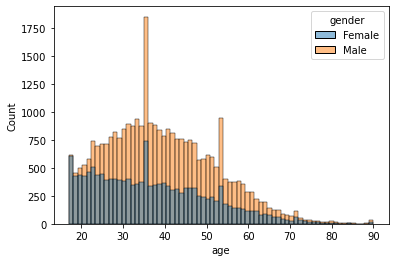

In [24]:
sns.histplot(data=df, x="age", hue="gender")
# It clearly has 2 modes

<AxesSubplot:xlabel='income', ylabel='Count'>

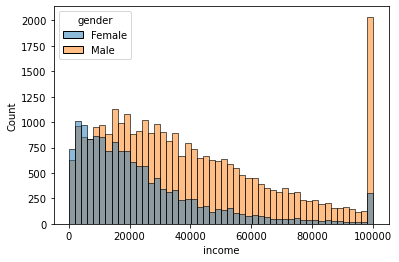

In [25]:
sns.histplot(data=df, x="income", hue="gender")

##### Let's check for which categorical data feature engineering is worth it

In [26]:
def drawPlot(xName):

    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x=xName,
        y='income',
        data=df.sort_values(xName),
        ax=axs[0]
    )

    sns.countplot(
        x=xName,
        data=df.sort_values(xName),
        ax=axs[1]
    )

    # Draw median price
    axs[0].axhline(
        y=df['income'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

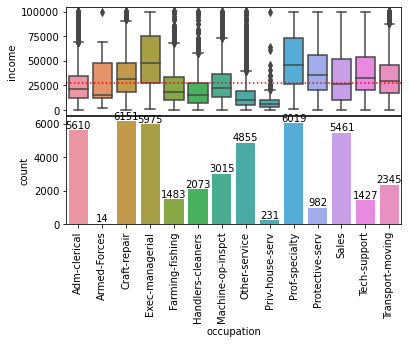

In [27]:
drawPlot("occupation")

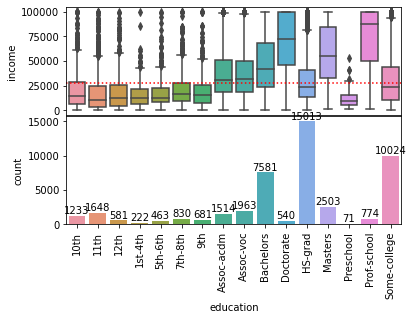

In [28]:
drawPlot("education")

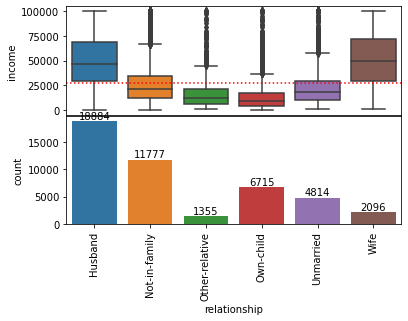

In [29]:
drawPlot("relationship")

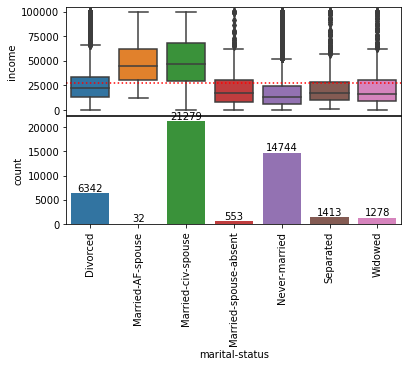

In [30]:
drawPlot("marital-status")

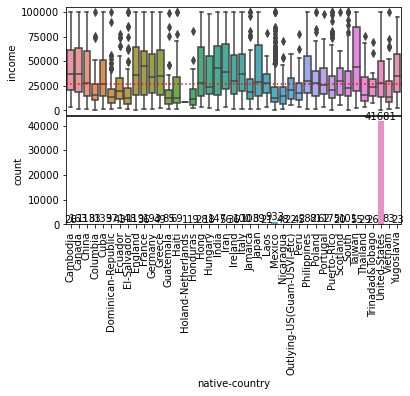

In [31]:
# Very biased, so no feature engineering on this feature
drawPlot("native-country")

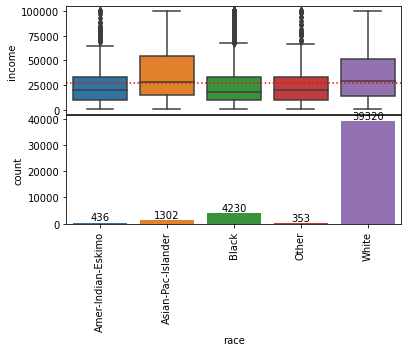

In [32]:
# Very biased, so no feature engineering on this feature as well as not on gender
drawPlot("race")

### Check for Outliers

<AxesSubplot:xlabel='hours-per-week', ylabel='Count'>

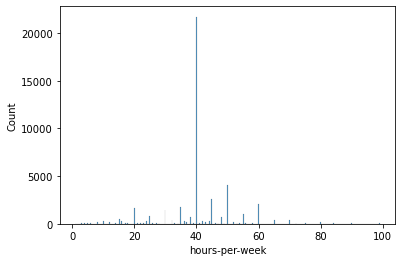

In [33]:
sns.histplot(df['hours-per-week'])

<AxesSubplot:xlabel='income', ylabel='Count'>

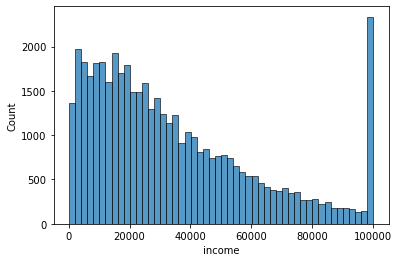

In [34]:
sns.histplot(df['income'])

<AxesSubplot:xlabel='age', ylabel='Count'>

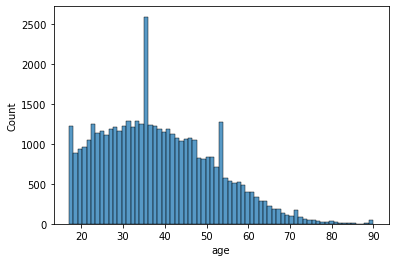

In [35]:
sns.histplot(df['age'])

<AxesSubplot:xlabel='education-num', ylabel='Count'>

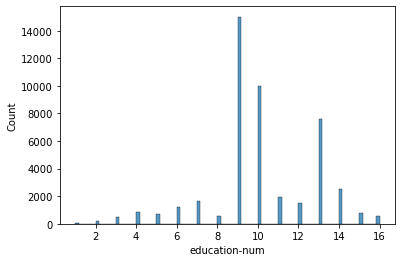

In [36]:
sns.histplot(df['education-num'])

<AxesSubplot:xlabel='capital-gain', ylabel='Count'>

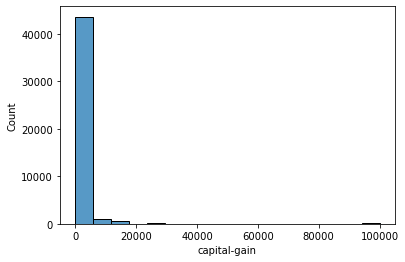

In [37]:
sns.histplot(df['capital-gain'])

<AxesSubplot:xlabel='capital-loss', ylabel='Count'>

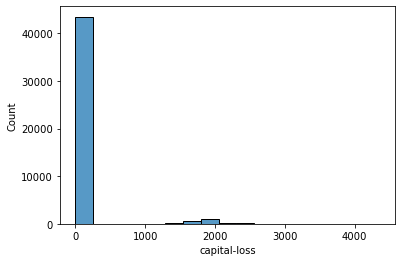

In [38]:
sns.histplot(df['capital-loss'])

In [39]:
# Are the 0's in capital-gain and capital-loss missing values or indeed 0?

# 4) Create The Preprocessing Pipeline <a name="prepro"></a>

In [40]:
def select_columns(data, *columns):
    all_columns = []

    for val in data.columns:
        if val.startswith(columns):
            all_columns.append(val)

    return data.reindex(columns = all_columns)

In [41]:
def standardize_columns(data,epsilon=1e-100):
    standardized_data = (data - np.mean(data))/(np.std(data) + epsilon)
    return standardized_data

In [42]:
def remove_outliers_sd(data, variable):

    return data.loc[(np.abs(stats.zscore(data[variable])) < 3)]

In [43]:
def remove_outliers_bound(data, variable, lower=-np.inf, upper=np.inf):

    return data.loc[(data[variable] > lower) & (data[variable] < upper)]

In [44]:
def rmse(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    # Normalized RMSE
    return rmse/(max(actual)-min(actual))

###### Create function for dummy values for all categorical data

In [45]:
def oheCategoricalData(data):
    to_drop = ["workclass", "education", "marital-status", "relationship", "race", "native-country", "occupation", "gender"]
    dummy_vars = pd.get_dummies(data[to_drop])
    data = pd.concat([data.drop(to_drop, axis=1), dummy_vars], axis = 1)
    return data


###### Create functions for feature engineering

In [46]:
def find_highIncome(xName, data, n=3, metric=np.median ):
    return data.groupby(xName).agg(metric).sort_values(by=["income"],ascending=False).iloc[:n].index.values.tolist()

def add_in_highIncome(data, highIncome, xName):
    data["in_rich_"+xName] = 0
    mask = data[xName].isin(highIncome)
    data.loc[mask,"in_rich_"+xName] = 1
    return data, "in_rich_"+xName

In [47]:
def process_data(data):
    # Drop NaNs and duplicates
    data['workclass'] = data['workclass'].replace('?', np.nan)
    data['occupation'] = data['occupation'].replace('?', np.nan)
    data['native-country'] = data['native-country'].replace('?', np.nan)
    data.dropna(how='any', inplace=True)
    data = data.drop_duplicates()
    
    # Feature Engineering
    rich_Occupation = find_highIncome('occupation', data, n=3, metric=np.median )
    data, richOccs = add_in_highIncome(data, rich_Occupation, 'occupation')
    
    rich_Education = find_highIncome('education', data, n=3, metric=np.median )
    data, richEds = add_in_highIncome(data, rich_Education, 'education')

    rich_rel = find_highIncome('relationship', data, n=3, metric=np.median )
    data, richRels = add_in_highIncome(data, rich_rel, 'relationship')

    rich_MS = find_highIncome('marital-status', data, n=1, metric=np.median )
    data, richMS = add_in_highIncome(data, rich_MS, 'marital-status')
    
    # Create dummy variables for categorical    
    data = oheCategoricalData(data)



    data = (
        data
        # Clean Data
        .pipe(remove_outliers_sd, 'hours-per-week') # (681 outliers)
        .pipe(remove_outliers_bound, 'income', upper = 99497 ) 

        # Transform data
        .pipe(select_columns, 
              'age',                                 
              'education-num', 
              'workclass',
              'hours-per-week',
              'income',
              richOccs,
              richEds,
              richMS,

             )
    ) 
    
    # X = standardize_columns(data).drop(['income'], axis = 1)
    X = data.drop(['income'], axis = 1)
    y = data['income']
    
    return X, y

# 5) Analysis Methods <a name="modelling"></a>

5. Can we predict if the yearly income of a person is above 50k dollars or lower with logistic regression and decision trees?
6. Which machine learning model performs better in terms of RMSE (for Q5)?


In [101]:
main_df = pd.read_csv('adult_reconstruction.csv')
X, y = process_data(newDATA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

In [102]:
display(X_train)

,hours-per-week,age,education-num,in_rich_occupation,in_rich_education,in_rich_marital-status,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
23158,50,18,10,0,0,0,0,0,1,0,0,0,0
6643,16,75,2,0,0,1,0,0,1,0,0,0,0
190,50,28,9,0,0,0,0,0,1,0,0,0,0
9439,40,20,10,0,0,0,0,0,1,0,0,0,0
16104,45,36,12,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6988,22,27,10,0,0,0,0,0,1,0,0,0,0
6693,38,26,10,0,0,0,0,0,1,0,0,0,0
7431,49,24,9,0,0,0,0,0,1,0,0,0,0
8556,50,26,9,0,0,1,0,0,1,0,0,0,0


#### Lasso Model

In [103]:
from sklearn import linear_model as lm
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas,cv=5, max_iter = 10000)
final_model.fit(X_train, y_train)

y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

train_score = rmse(y_predicted_train, y_train)
test_score = rmse(y_predicted_test, y_test)

print("RMSE Train: ", train_score, " RMSE Test: ", test_score)

RMSE Train:  0.16011024132456855  RMSE Test:  0.16750806991109085


### Comparing Plots of Test and Predicted Income Values Based on Gender

In [104]:
test_copy = X_test.copy()
test_copy = pd.concat([X_test, y_test], axis = 1)
test_copy['prediction'] = y_predicted_test

test_copy['gender'] = df[df.index.isin(test_copy.index)]['gender']
test_copy['occupation'] = df[df.index.isin(test_copy.index)]['occupation']

<AxesSubplot:xlabel='income', ylabel='Count'>

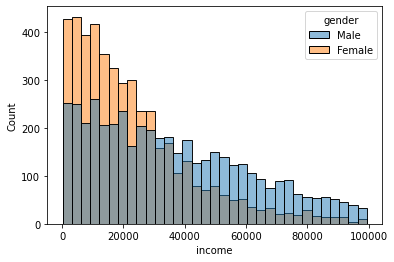

In [105]:
sns.histplot(data=test_copy, x='income', hue="gender")

<AxesSubplot:xlabel='prediction', ylabel='Count'>

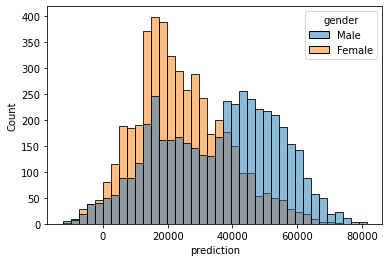

In [106]:
sns.histplot(data=test_copy, x='prediction', hue="gender")

In [165]:
for d in dictt:
    test_copy=test_copy.replace(d, dictt[d])

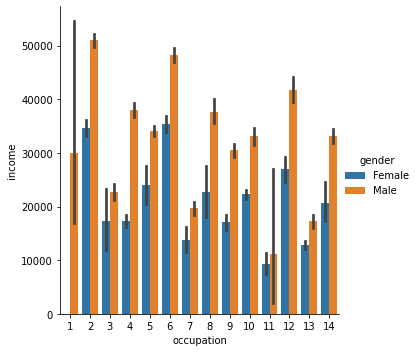

In [166]:
sns.catplot(data=test_copy, kind="bar", x="occupation", y="income", hue="gender")

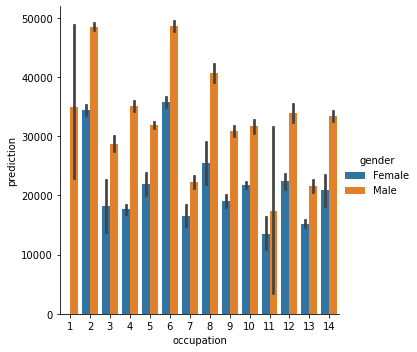

In [167]:
sns.catplot(data=test_copy, kind="bar", x="occupation", y="prediction", hue="gender")

#### Logistic Regression

In [168]:
# from sklearn.linear_model import LogisticRegression
# final_model2 = LogisticRegression(random_state=0)
# final_model2.fit(X_train, y_train)
# y_predicted_train2 = final_model2.predict(X_train)
# y_predicted_test2 = final_model2.predict(X_test)

# train_score2 = rmse(y_predicted_train2, y_train)
# test_score2 = rmse(y_predicted_test2, y_test)

# print("RMSE Train: ", train_score2, " RMSE Test: ", test_score2)

# # wtf am i doing wrong??????????????????????


#### Decision Trees

In [50]:
# from sklearn.tree import DecisionTreeClassifier
# final_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

# y_predicted_train = final_model.predict(X_train)
# y_predicted_test = final_model.predict(X_test)

# train_score = rmse(y_predicted_train, y_train)
# test_score = rmse(y_predicted_test, y_test)

# print("RMSE Train: ", train_score, " RMSE Test: ", test_score)

# Ethical Considerations <a name="ethics"></a>